In [ ]:
import nltk
from os import getcwd
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 
from utils import process_tweet, build_freqs
import matplotlib.pyplot as plt

In [4]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\merie\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\merie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [6]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [7]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [8]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [12]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11397


In [13]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


In [14]:
# UNQ_C1 GRADED FUNCTION: sigmoid
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    h = 1/(1+np.exp(-z))
    
    return h

In [42]:
# UNQ_C2 GRADED FUNCTION: gradientDescent
def gradientDescent(x, y, theta, alpha, num_iters):
    ### START CODE HERE ###
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    b = 0
    j_hist = []
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta) + b
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1/m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
        j_hist.append(float(J))
        
        dTheta = (1/m) * np.dot(x.T, (h - y))
        db = np.mean(h - y)

        # update the weights theta
        theta = theta - dTheta * alpha
        b = b- db * alpha
        
    ### END CODE HERE ###
    J = float(J)
    return J, theta, b, j_hist

In [44]:
# UNQ_C3 GRADED FUNCTION: extract_features
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a string containing one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
    ### START CODE HERE ###
    
    # loop through each word in the list of words
    for word in word_l:
        
        if (word, 1.0) in freqs:
            # increment the word count for the positive label 1
            x[1] += freqs[(word, 1.0)]
        
        if (word, 0.0) in freqs:
            # increment the word count for the negative label 0
            x[2] += freqs[(word, 0.0)]
        
    ### END CODE HERE ###
    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

In [45]:
# Check your function
# test 1
# test on training data
tmp1 = extract_features(train_x[0], freqs)
print(tmp1)

[[1.000e+00 3.133e+03 6.100e+01]]


In [46]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features('blorb bleeeeb bloooob', freqs)
print(tmp2)

[[1. 0. 0.]]


In [48]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta, b, j_hist = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")
print(f"The bias after training is {b:.8f}")

The cost after training is 0.22524410.
The resulting vector of weights is [6e-08, 0.00053786, -0.00055885]
The bias after training is 0.00000006


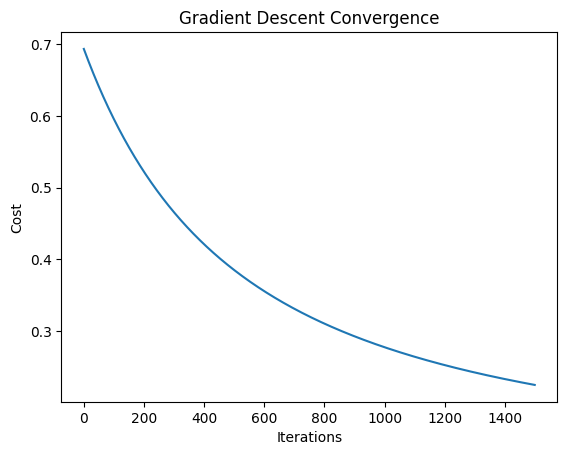

In [50]:
plt.plot(j_hist) 
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.show()

In [51]:
# UNQ_C4 GRADED FUNCTION: predict_tweet
def predict_tweet(tweet, freqs, theta, b):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    ### START CODE HERE ###
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs, process_tweet=process_tweet)
    z = np.dot(x, theta) + b
    y_pred = sigmoid(z)
    
    
    ### END CODE HERE ###
    
    return y_pred

In [52]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta, b)))    
    

I am happy -> 0.519259
I am bad -> 0.494338
this movie should have been great. -> 0.515962
great -> 0.516052
great great -> 0.532070
great great great -> 0.548023
great great great great -> 0.563877


In [53]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta, b)

array([[0.83096619]])

In [62]:
# UNQ_C5 GRADED FUNCTION: test_logistic_regression
def test_logistic_regression(test_x, test_y, freqs, theta, b, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    ### START CODE HERE ###
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta, b)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.mean(np.array(y_hat) == np.squeeze(test_y))

    ### END CODE HERE ###
    
    return accuracy

In [63]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta, b, predict_tweet=predict_tweet)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9965


In [65]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta, b)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48927136	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: off to the park to get some sunlight : )
THE PROCESSED TWEET IS: ['park', 'get', 'sunlight']
1	0.49632428	b'park get sunlight'
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.48246191	b'uff itna miss karhi thi ap :p'
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.50983760	b'u prob fun david'
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 

In [67]:
# Feel free to change the tweet below
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta, b)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48122779]]
Negative sentiment
